## EX03_making_sticker_camera


스티커 카메라 모델만들기 방법은 다음 과정을 거쳐서 만들 것이다.

### step1. 사진준비
### step2. 사진에서 얼굴의 bounding box를 찾아낸 다음 얼굴영역(face landmark)를 찾는다.
    step2-1. 얼굴 검출(face detection)
    step2-2. face landmark
### step3. 찾은 영역에 왕관 스티커를 붙인다.

- 스티커를 이목구비에 자연스럽게 추가하기 위해서는 얼굴의 각각의 위치를 정확히 알아야한다.

- 이미지의 이목구비를 찾는 기술은 keypoint detection의 하위부류로 랜드마크(landmark) 혹은 조정(alignment)라고 부른다.
- 얼굴의 포인트가 되는 랜드마크를 중심으로 내가 원하는 위치를 찾아가면 된다.


In [1]:
import os
import cv2       # 이미지처리 알고리즘이 들어있는 라이브러리
import matplotlib.pyplot as plt # 이미지 시각화
import numpy as np  # onpencv에서 불러온 이미지들이 numpy 배열로 저장되니까 꼭 필요 
import dlib

 ## Step1. 사진 준비
 - opencv 라이브러리를 사용하여 이미지를 불러온다.
 - opencv라이브러리는 다른 이미지처리하는 라이브러리와 달리 채널 순서가BGR이므로 주의한다.

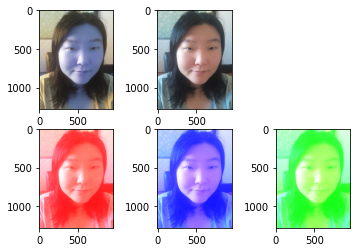

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/I.jpg' # 얼굴사진의 디렉터리 경로
img_bgr = cv2.imread(my_image_path,cv2.IMREAD_COLOR)  # opencv의 cv2.imread 함수를 사용하여 이미지를 불러온다.

  
plt.Figure(figsize=(10,20))
plt.subplot(231)
plt.imshow(img_bgr) # opencv를 통해 가져온 이미지를 그대로 출력(BGR순서)의 이미지 값을 출력한다

plt.subplot(232)
img_rgb=cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # cv2.cvtColor함수를 사용하여 BGR순서의 이미지채널을 RGB순서로 바꾼다.
img_show = img_bgr.copy()      
plt.imshow(img_rgb) 

R_rgb,G_rgb,B_rgb=img_rgb.copy(),img_rgb.copy(),img_rgb.copy()
R_rgb[:,:,0],G_rgb[:,:,1],B_rgb[:,:,2]=255,255,255

plt.subplot(234)
plt.imshow(R_rgb)

plt.subplot(235)
plt.imshow(B_rgb)

plt.subplot(236)
plt.imshow(G_rgb)

plt.show()


opencv로 바로 읽어온 이미지의 피부가 파란 모습으로 나온다. 색이 이렇게 이상한 이유는 matplotlib의 plt.imshow함수와 PILOW를 비롯한 이미지툴이 이미지를 저장할때 numpy의 배열의 컬러 채널의 순서가  RGB의 순서로 구성되어있다.[EX01 가위바위보 프로젝트에 설명 참조](https://github.com/Asunny2019/AIFFEL_Exploration/blob/main/E01_rock_scissor_paper.ipynb) 

그러나  opencv는 BGR의 순서로 이미지 채널을 저장한다. __G는 가운데에 있어서 그대로 값을 유지하지만 빨간색의 색정보가 파란색의 색정보가 된다. 그래서 원본에 보이는 얼굴의 붉은 색이 왼쪽 이미지의 푸른색으로 바뀌어서 파란 얼굴이 된다.__   
아랫줄의 세장의 이미지 사진처럼 원본 이미지의 특정 색채널의 값을 255로 바꾸면 그 색이 두드러진다. 첫번째 이미지는 빨간색 채널을 255로 바꿨기 때문에 빨간색 이미지가 진하게 나온다. 다른 이미지도 각각 G, B의 채널값을 255로 바꾸면 이렇게 색이 변한다.

우리가 일반적으로 보는 이미지처럼 numpy 배열을 구성하려면 

   __첫째. cv2.imread()함수를 쓸때 두번째 인자인 flag__ 를 아래와 같이 설정해주어야한다

- cv2.imread(파일 경로, flag)

cv.IMREAD_COLOR(혹은 1): 컬러로 이미지를 읽어온다.  
cv.IMREAD_GRAYSCALE(혹은 0): 이미지를 그레이 스케일로 읽어들인다.이미지 처리할때 중간단계로 많이 씀  
cv2.IMREAD_UNCHANGED(혹은 -1): 이미지 파일의 alpha channel까지 읽어온다.  

   __둘째. cv2.cvtColor__ 로 BGR이미지를 RGB로 바꿔주어야한다. 
  
  
  -------------------------------------
  
## step2. 사진에서 얼굴의 bounding box를 찾아낸 다음 얼굴영역(face landmark)를 찾는다.
   
   #### step2-1. 얼굴 검출(face detection) - dlib라이브러리
  공개된 object detection 패키지를 사용하여 따로 학습하지 않고 얼굴의 위치를 찾아보자. dlib라이브러리는 __HOG__ 알고리즘으로 이미지의 특징(픽셀의 그레디언트)을 잡아내어 SVM으로 분류해내는 모델을 사전학습을 시킨 모델을 제공한다. 이 모델을 사용하셔서 사진에 있는 얼굴 이미지를 찾아낸다. 
    
   - HOG(Histogram of Oriented Gradients)란?
   : 이미지의 지역적인 Gradient를 영상의 특징으로 사용하는 방법으로 이 방법을 사용하여 객체를 검출한다. 이미지 색상의 그레디언트를 사용하여서 이미지의 edge를 HOG알고리즘을 사용해서 특징(이미지의 외곽선이 색상과 밝기 차이가 크다는 점에서 착안)을 만들어내고, 이 특징을 기계학습에 적용해서 객체를 찾아낸다. [참조](https://hohodu.tistory.com/19)
   HOG로 특징을 뽑아내는 과정에서 당시 컴퓨터 비전을 연구하는 과학자들은 소버마스크(혹은 소버필터) 등을 만들어내서 이미지의 Edge를 찾아내었다. 
   
   - SVM(Support Vector Machine)이란?
   : 초평면을 사용하여 고차원 공간에 있는 여러 벡터를 구분짓는 방법으로 객체를 분류해내는 역할을 한다. 
   ![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/2a/Svm_max_sep_hyperplane_with_margin.png/330px-Svm_max_sep_hyperplane_with_margin.png)
   
   - 슬라이딩 윈도우(sliding window)
   : 이미지의 작은 영역을 확인하고 한 픽셀씩 옆으로 이동하는 방법으로 이미지의 객체를 탐지하는 방법이다. 
   ![](https://blog.kakaocdn.net/dn/plPuT/btqCbUEbIQn/XV45cw3Bta1us71u9CJ1Sk/img.gif)

In [3]:
detector_hog = dlib.get_frontal_face_detector()   # get_frontal_face_detector를 선언한다.


img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR로 있던 이미지를 RGB로 변경
dlib_rects = detector_hog(img_rgb, 1)   # detector_hog(이미지, 이미지 피라미드 수=1)

- 이미지의 피라미드 수
: 이미지를 여러스케일에 걸쳐 분석하는 가장 기본적인 방법은 이미지의 크기를 단계적으로 변화시켜가면서 필요한 분석작업을 하는 것으로 이렇게 생성된 일련의 이미지 집합을 이미지 피라미드라고 부른다. opencv의 image pyramid의 설명에 따르면 동일한 이미지에 대해서 다양한 사이즈로 작업해야하는 경우 사용한다고 한다.
[참조|](https://darkpgmr.tistory.com/137)
![](https://www.pyimagesearch.com/wp-content/uploads/2015/03/pyramid_example.png)

- detector_hog(img_rgb,1) , 이 코드에서는 이미지를 그대로 쓰고 있다.

detector_hog에 의해 만들어진 지금 제시한 사진에는 사람이 한명이라 dlib_rects에 하나만 출력된다. 여러명일 경우 바운딩 박스가 dlib_rect에서 검출된 얼굴의 갯수만큼 저장된다.

In [4]:
print(dlib_rects)   # dlib 라이브러리의 detector_hog가 찾아낸 얼굴의 좌표를 출력한다.

for dlib_rect in dlib_rects: 
    l = dlib_rect.left() # 왼쪽좌표
    t = dlib_rect.top()  # 위의 좌표
    r = dlib_rect.right() #오른쪽 좌표
    b = dlib_rect.bottom() #아래의 좌표

    cv2.rectangle(img_show, (l,t), (r,b), (255,0,255), 4, lineType=cv2.LINE_AA)

rectangles[[(206, 280) (872, 946)]]


### cv2.rectangle(img_show, (l,t), (r,b), (255,0,255), 4, lineType=cv2.LINE_AA)
- opencv의 __사각형 그리는 함수__로 
- 첫번째 인자는 사각형을 그릴 이미지, 두번째 인자는 (왼쪽,위쪽), 세번째 인자는 (오른쪽, 아래)좌표
-  네번째 인자는 사각형 색깔로 (BGR) 중에서 B와 R을 255그리고 G를 0으로 해서 보라색 박스를 만들었다.
-  다섯번째 인자는 사각형의 선 굵기이다
-  여섯번째 인자는 라인타입으로 cv2.LINE_AA는 [안티앨리어싱](https://github.com/Asunny2019/AIFFEL_Exploration/blob/main/E01_rock_scissor_paper.ipynb)을 말한다.


In [5]:
print(type(dlib_rects)) # rectangles 라는 객체타입
print(dlib_rects[0].left(),dlib_rects[0].right(), dlib_rects[0].top(), dlib_rects[0].bottom())

<class '_dlib_pybind11.rectangles'>
206 872 280 946


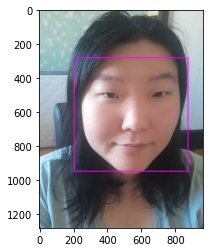

In [6]:
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB) 
plt.imshow(img_show_rgb)
plt.show()

detector_hog가 찾아낸 얼굴을 rectangles라는 객체로 반환받았다. 왼쪽, 오른쪽, 위 아래의 좌표를 받아온 후에 opencv의 __cv2.rectangle 함수를 사용하여 이미지 img_show 위에 보라색 박스__ 를 얹어보았다. 위와 같이 얼굴에 정확하게 보라색 사각형이 얹어진 것을 볼수 있다. 알고리즘이 정확히 얼굴을 찾아내었다.



### step2-2. face landmark

- 이렇게 바운딩 박스로 얼굴을 찾았으니 고양이 수염스티커를 적절한 위치에 붙이기 위해서 박스 안의 이목구비의 위치를 찾아보자.
- 이렇게 이목구비의 위치를 찾는 것을 face landmark localization 기술이라고 한다. detection 된 얼굴 이미지를 잘라내어서 랜드마크를 찍어보자.

- __object keypoint estimation__ 알고리즘이란?
: 객체 안의 특징점을 찾는 기술이다. 박스 안에서 세부적인 특징점들을 찾는 top-down 방식과 세부 특징점을 찾은 후에 점들의 관계를 사용하여서 박스를 생성하는 방법이 있다. 내가 배우고 사용하는 방법은 top-down 방식을 사용하여서 이목구비의 랜드마크를 찍을 것이다. 

- 얼굴의 이목구비를 탐색하는 포인트의 개수는 데이터셋과 논문마다 다르지만 Dlib가 사용한 데이터셋은 ibug 300-W 데이터셋으로 학습되어진 모델을 제공한다. 이 데이터셋은 총 68개의 랜드마크로 학습되었다. 
![](https://blog.kakaocdn.net/dn/baNXvY/btqChGYfEU4/l59Bgkbdir5CQ4wdDqZIw0/img.png)

위 그림의 포인트에 해당하는 곳에 랜드마크의 좌표가 list_landmark에 입력되어있다. 앞에서 dlib_rects를 만드는 과정에서 설명했듯이 여러사람을 찾아낼 수 있도록 2차원 리스트로 만들어졌다. 지금은 한사람뿐이라서 왜 그런지 이해가 잘 안가겠지만  (예를들어 list_landmarks의 0번)

In [7]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path) # 미리 만들어진 face landmark 모델을 가져온다.

In [8]:
list_landmarks = [] # 랜드마크으 좌표를 넣을 빈 리스트

for dlib_rect in dlib_rects: # 박스의 좌표를 담은 리스트를 하나씩 가져온다.
    points = landmark_predictor(img_rgb, dlib_rect) 
    # 미리 학습된 모델에 이미지와 얼굴의 박스를 입력해주면 박스 안의 얼굴의 68개의 랜드마크 포인트 리스트를 반환한다..
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))  # points에서 가져온 랜드마크 리스의 x,y 점을 튜플로 가져온다.
    list_landmarks.append(list_points)   # 얼굴을 탐지한 박스의 개수 당 랜드마크68개를 반환.

print(len(list_landmarks[0])) # 총 몇개의 랜드마크가 있나?
print(list_landmarks[0][:3]) # 0번 인덱스의 얼굴박스의 랜드마크 1번부터 3번까지 반환한다.(위의 랜드마크 포인트 이미지 참조)

68
[(251, 483), (245, 565), (249, 649)]


In [9]:
print(dlib_rects)

rectangles[[(206, 280) (872, 946)]]


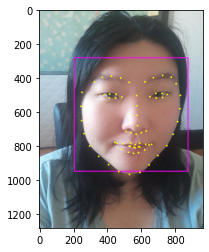

In [10]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 5, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Step3. 스티커 적용위치 확인하기

1. 스티커 위치가 코끝에 스티커 이미지의 한쪽 면에 붙어있길래 코끝을 중심으로 다음과 같이 이미지를 조절했다. 스티커 이미지의 절반
만큼 왼쪽으로 옮기기 위해서 weight의 절반을 x좌표에서 빼주고, y는 가장 적절한 위치에 넣기 위해서 픽셀수를 올리고 내리면서 조절했다.

$$x=x_{코끝}-(weight//2)$$
$$y=y_{코끝}-10$$

2. 스티커 크기

$$width=height=width_{bbox}$$

In [11]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # 코의 index는 30 입니다
    x = landmark[33][0]
    y = landmark[33][1] - dlib_rect.height()//2
    w = h = dlib_rect.width() 
    print ('(x,y) : (%d,%d)'%(x,y)) # 코의 중심점
    print ('(w,h) : (%d,%d)'%(w,h))

(568, 729)
(x,y) : (568,396)
(w,h) : (667,667)


(667, 667, 3)


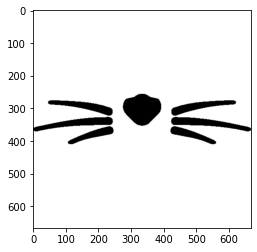

In [12]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)
plt.imshow(img_sticker)


고양이 수염 스티커 이미지로 사용하기 위해서 받아온 png 파일의 shape는 667,667,3이다. 가로세로 픽셀은 각각 667이고 채널수는 3개(RGB)이다.

In [13]:
v1=img_sticker.reshape(-1)
np.unique(v1)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160,
       161, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 18

위의 스티커 이미지를 그대로 불러와서 얼굴사진에 붙여보았더니 
![](https://github.com/Asunny2019/AIFFEL_Exploration/blob/main/img/error.JPG?raw=true)
이런 이미지가 되었다. 이 문제를 해결하기 위해서 스티커에 아래의 과정을 거쳤다.

1. 색반전  
그래서 어떻게 수염부분만 남기고 배경을 지울까 생각해보니까 색반전을 하면 흰색이 검은색이 되어서 배경을 지울수 있겠다는 생각이 들었다.

2. 이진화  
바로 위의 셀은 스티커 이미지의 배열에서 유일한 값들만 뽑아내어보니까 다양한 값들이 있는 것을 발견했다 깔끔하게 이미지를 합성하기 위해서, 이미지의 모든 픽셀을 150이하를 0, 150을 초과하면 255으로 만들어서 값을 이진화 시켰다.

3. 255값을 5로 바꿔준다.   
색반전하고 이진화를 하면 하얀색 수염이 나오게 된다.하지만 원하는 것은 검은색 수염이기 때문에 검은색이 나오도록 처음엔 255값을 0으로 바꿨는데 자꾸 수염이 사라졌다. 스티커를 붙이는 코드를 보니까, 스티커 이미지(img_sticker)의 0인 부분을 얼굴이미지로 바꿔준다. 그래서 어두운 색 수염을 만드는 것으로 목표로 하고 0이 아닌 5로 수정을 했다. 자세한 것은 밑의 스티커 붙이는 코드에서 더 설명하겠다.


(667, 667, 3)


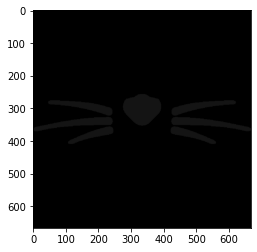

In [15]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))

img_sticker = 255-img_sticker # 색반전
img_sticker[img_sticker>150]=255 # 이진화
img_sticker[img_sticker<=150]=0  # 이진화
img_sticker[np.where(img_sticker==255)]=20 # 픽셀값이 255인 픽셀값을 5로 바꿔준다.  
print (img_sticker.shape)
plt.imshow(img_sticker)

# 자세히보면 약간 밝은 색으로 고양이 수염이 보인다.

In [17]:
refined_x=x-(w//2) # 재수정된 스티커의 위치: 위에서 적은 수식을 그대로 적었다.
refined_y=y  

print('(x,y) : (%d,%d)'%(refined_x, refined_y)) 

(x,y) : (235,396)


- 내가 가져온 스티커는 얼굴이미지를 벗어나지 않아서 (음수가 아니므로) 혹시라도 벗어나면 다음셀의 코드를 돌려서 스티커 이미지를 crop 시켜준다.
- x 혹은 y가 음수가 나오는 이유는 얼굴의 사진 영역을 벗어나기 때문에 음수가 나온다. 
- 스티커의 시작점과 스티커사진의 크기를 더한 값이 원본 이미지의 크기보다 큰 경우도 음수가 나온다.

In [18]:
if refined_x < 0:      # 만일 지정한 스티커의 위치가 음수가 되면, 
    img_sticker=img_sticker[:, -refined_x:]   # x좌표 스티커가 벗어난 것 만큼 crop
    refined_x=0
if refined_y < 0:
    img_sticker=img_sticker[-refined_y:,:]    # y좌표 스티커가 벗어난 것 만큼 crop
    refined_y=0
    
print("(x,y) :(%d,%d)"%(refined_x, refined_y)) # x좌표와 y좌표를 조정한 값

(x,y) :(235,396)


다음 줄의 코드를 보기 전에 np.where 함수의 가장 간단한 설명을 보고 들어가야할 것 같다.

In [19]:
a=np.array([20,5,7,3,24,6,8,38])
np.where(a > 15, True, False) 

array([ True, False, False, False,  True, False, False,  True])

np.where함수의  
첫번째 인자는 numpy 배열 a을 포함한 조건문이 들어간다.  
두번째 인자는 a가 참인 인덱스에 들어갈 값  
세번째 인자는 a가 거짓인 인덱스에 들어갈 값을 넣어준다. 

## Step 4. 스티커 적용하기

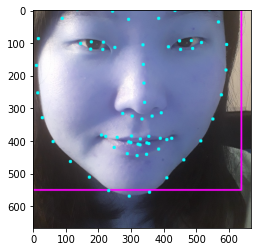

In [20]:
sticker_area=img_show[refined_y: refined_y+img_sticker.shape[0], refined_x: refined_x + img_sticker.shape[1]] 
# 얼굴 이미지에 스티커가 붙을 위치 만큼을 crop한다. 
plt.figure(figsize=(4,4))
plt.imshow(sticker_area)
plt.show()

In [21]:
img_show[refined_y: refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]=np.where(img_sticker==0, sticker_area, img_sticker).astype(np.uint8)

# 얼굴이미지의 스티커가 붙을 위치에 where함수를 사용해서 값을 바꿔준다..

np.where(img_sticker==0, sticker_area, img_sticker).astype(np.uint8)

np.where 함수을 뜯어보면, img_sticker==0 인 조건이 참인 값(스티커의 배경)에는 sticker area의 픽셀값(얼굴이미지)이 들어가고 조건이 거진인(0이 아닌 곳, 즉 고양이 수염)인 곳은 스티커 이미지를 넣는 코드이다.  
그래서 흰색인 고양이 수염이미지를 어둡게 만든다고 0으로 만들면 사람 얼굴이미지가 들어가버리기 때문에 0이 아닌 어두운 색깔인 5나 10 값으로 바꿔주는 것이 적절하다.

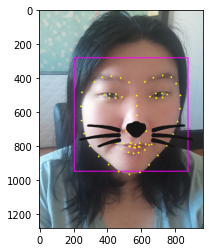

In [22]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

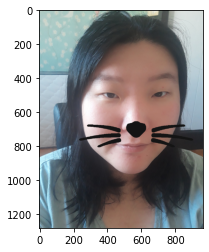

In [23]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### cv2.addWeighted를 사용해서 두 이미지를 합치기
$$g(x) = (1-\alpha)f_{0}(x)+\alpha f_{1}(x)$$
- $g(x)$는 합성된 이미지, 결과물이다.  $f_{0}$와 $f_{1}$은 합칠 이미지이다. 그리고 $\alpha$는 이미지를 얼마나 진하게 합치느냐, 즉 가중치를 말한다. 수식에서 볼수 있듯이 두 가중치는 더해서 1이 되도록 만든다. 
- 입력되는 두장의 이미지는 사이즈가 같아야지 사용할 수 있는 함수이다.

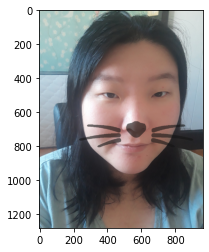

In [24]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/I.jpg' # 얼굴사진의 디렉터리 경로
img_bgr1 = cv2.imread(my_image_path,cv2.IMREAD_COLOR)  # opencv의 cv2.imread 함수를 사용하여 이미지를 불러온다.

w=0.6
alpha,beta=w, 1-w
l=cv2.addWeighted(img_bgr, alpha, img_bgr1, beta, 0.0) 
# 첫번째 인자는 더할 이미지1, 두번째는 이미지1의 가중치, 3번째는 더할 이미지2, 4번째는 이미지2의 가중치

plt.imshow(cv2.cvtColor(l, cv2.COLOR_BGR2RGB))
plt.show()

내가 보기에는 적당한 위치에 고양이 수염을 붙인것으로 보인다.

## Step 5. 문제점 찾아보기


여러 각도와 한장의 이미지에 여럿이 보이는 장면을 테스트해보고 싶었다. 처음에 이 시도를 하려니까 코드가 지나치게 길어져서 
1. 코드의 길이를 줄이기 위해서 함수로 만들고
2. 한장의 이미지에 여러사람의 얼굴을 찾아서 고양이 수염을 붙이기 위해서 반복문으로 랜드마크를 찍을수 있도록 하였다.

In [30]:
def cat_sticker(path):
    detector_red1=dlib.get_frontal_face_detector() 
    red=os.getenv('HOME')+path

    img_red=cv2.imread(red, cv2.IMREAD_COLOR)
    img_red1_show=img_red.copy()
    dlib_rects1=detector_hog(img_red,1)
    
    for dlib_rect in dlib_rects1: 
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()
        
        cv2.rectangle(img_red, (l,t), (r,b), (255,0,255), 2, lineType=cv2.LINE_AA)
        
    img_show_rgb =  cv2.cvtColor(img_red, cv2.COLOR_BGR2RGB) 
    landmark_predictor = dlib.shape_predictor(model_path) # 미리 만들어진 face landmark 모델을 가져온다.
    list_landmarks = [] # 랜드마크 좌표를 넣을 빈 리스트
    for dlib_rect in dlib_rects1: # 박스의 좌표를 담은 리스트를 하나씩 가져온다.
        points = landmark_predictor(img_red, dlib_rect) 
        # 미리 학습된 모델에 이미지와 얼굴의 박스를 입력해주면 박스 안의 얼굴의 68개의 랜드마크 포인트 리스트를 반환한다..
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))  # points에서 가져온 랜드마크 리스의 x,y 점을 튜플로 가져온다.
        list_landmarks.append(list_points)   # 얼굴을 탐지한 박스의 개수 당 랜드마크68개를 반환.

    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_show_rgb, point, 2, (0, 255, 255), -1)

    #img_show_rgb = cv2.cvtColor(img_show_rgb, cv2.COLOR_BGR2RGB)
    plt.imshow(img_show_rgb)
    plt.show()

    refined_x,refined_y,wid=[],[],[]
    for dlib_rect, landmark in zip(dlib_rects1, list_landmarks):
        x = landmark[33][0]
        y = landmark[33][1] - dlib_rect.height()//2
        w = h = dlib_rect.width() 
        refined_x.append(x-(w//2)) # 재수정된 스티커의 위치: 위에서 적은 수식을 그대로 적었다.
        refined_y.append(y)  ## y위치는 크게 벗어나지는 않아서 픽셀을 위아래로 조정하였다.
        wid.append(w)
        
    for i,j,w in zip(refined_x, refined_y,wid):
        img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
        img_sticker = cv2.resize(img_sticker, (w,w))

        img_sticker = 255-img_sticker # 색반전
        img_sticker[img_sticker>150]=255 # 이진화
        img_sticker[img_sticker<=150]=0  # 이진화
        img_sticker[np.where(img_sticker==255)]=5 # 픽셀값이 255인 픽셀값을 5로 바꿔준다.  
    
        sticker_area=img_red1_show[j: j+img_sticker.shape[0], i: i + img_sticker.shape[1]] 
        # 얼굴 이미지에 스티커가 붙을 위치 만큼을 crop한다. 
        img_red1_show[j: j+img_sticker.shape[0], i:i+img_sticker.shape[1]]=np.where(img_sticker==0, sticker_area, img_sticker).astype(np.uint8)


    plt.imshow(cv2.cvtColor(img_red1_show, cv2.COLOR_BGR2RGB))
    plt.show()

### test1. 화면에 얼굴이 꽉 차도록 좌, 우, 위에서 사진찍어서 테스트
- 좌측 첫번째 이미지는 정면에 가까운 측면이라서 탐지가 잘 되었지만, 좌측으로부터 2번째 3번째 이미지처럼 얼굴의 절반 이상이 한쪽 얼굴면만 보이는 경우에는 탐지가 잘 되지 않았다.
- 가장 오른쪽의 이미지처럼 위에서 아래로 내려찍는 얼굴의 경우도 탐지가 되지 않는다. 
-  고개를 살짝 돌린 측면 얼굴은 탐지가 잘 되지만, 얼굴의 절반 이상이 오른쪽 얼굴 혹은 왼쪽 얼굴인 경우는 얼굴 탐지가 안되었다. 다만 얼굴이 사진에 꽉차게 보여져서 얼굴 탐지가 안될 가능성이 있다고 생각이 들었다.

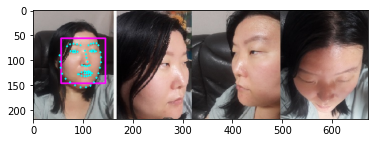

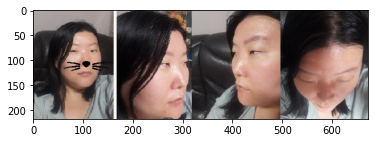

In [31]:
cat_sticker('/aiffel/camera_sticker/images/test.jpg')

### test2. 이미지 사이즈 중간, 한쪽 얼굴면이 얼굴의 절반 이상 보이도록 사진 찍기
- test1에서 얼굴의 사진에 꽉차는 사이즈로 한쪽면이 절반 이상 보이도록 한 사진을 탐색을 시켜보니까 탐지가 잘 안되었다. 
- test1의 결과가 얼굴만 보여지게 하여서 탐지가 안된건지 아니면 측면 얼굴로 찍어서 잘 안보인 것인지 체크하기 위해서, 얼굴이 사진의 정 중앙에 오고 대신 왼쪽 측면 얼굴과 오른쪽 측면 얼굴이 절반이상 보여지도록 찍은 사진을 찍어서 테스트를 해보았다
- 오른쪽 이미지는 탐지도 잘 되고 스티커도 측면 얼굴에 붙여서 조금 어색해도 잘 붙었다.
- 극단으로 고개를 돌렸던 두 이미지 중에서 턱, 코의 명암차이가 두드러지게 드러나고 머리카락을 들어올린 오른쪽 사진은 탐지가 잘되는데 반해 왼쪽 사진은 __코와 다른 뺨의 색의 차이가 적고 머리카락이 흘러내린 왼쪽 사진은 탐지가 잘 안되는 것__ 을 볼 수 있다. HOG가 면과 면사이의 차이가 많이 나야지 이미지의 특징을 많이 잡아내서 탐지를 잘 할텐데 왼쪽 이미지는 상대적으로 잘 안되나보다.
- 얼굴의 왼쪽은 

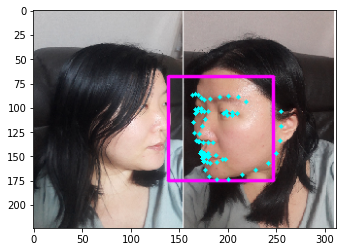

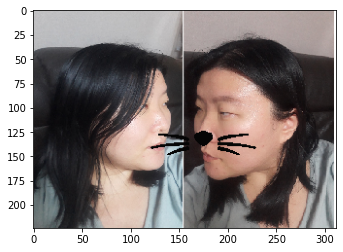

In [32]:
cat_sticker('/aiffel/camera_sticker/images/test2.png')

### test3. 화면 정중앙에 얼굴이 보이는 경우
- 얼굴이 감지가 잘 되면 좌우 위아래로 고개를 돌리거나 숙여도 얼굴의 양면이 화면 정중앙에 보이는 경우에는 탐지가 잘 된 것을 볼수가 있었다. 좌우로 얼굴이 돌려지는 경우는 기존의 스티커가 아니라 돌려진 고개에 맞도록 스티커를 회전시키는 방법을 고안해야할 것 같다. 고양이 수염이 부자연스럽게 떠있는 것을 확인할 수 있다.

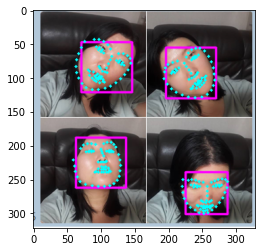

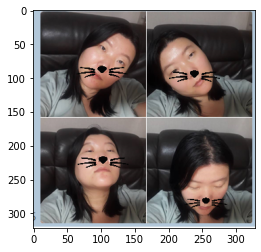

In [33]:
cat_sticker('/aiffel/camera_sticker/images/test3.png')

### test4. 어두운 경우와 상반신 전체가 나오는 경우
- 비록 화면이 어두워도 왼쪽 사진과 같이 탐지가 잘 된것을 확인할 수 있다. HOG기법이 사람눈으로 감지할 정도의 밝기에서는 어두워도 이미지의 배경과 객체의 밝기 차이가 있다면 이미지가 잘 탐지되는 것을 확인할수 있었다.
- 지금까지 얼굴이 꽉차거나 어깨선까지만 나오는 경우를 테스트해서 멀리 이미지가 있는 경우도 확인해본 결과 얼굴탐지가 잘되고 고양이 수염이 잘 붙은 것을 확인할 수 있었다.

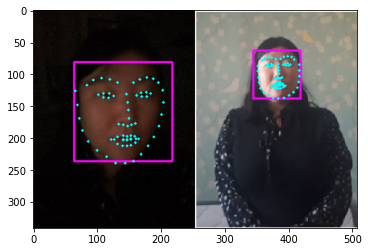

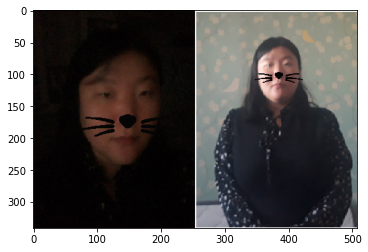

In [34]:
cat_sticker('/aiffel/camera_sticker/images/test4.png')

### 회고

0. 이미지에 관해서는 오늘 배운 이미지 알고리즘으로 이미지의 특징을 뽑아내어서 기계학습으로 객체 인식을 하는 것보다는 딥러닝이 인식율이 훨씬 좋다는 것은 알려진 사실이다. 그런데 왜 우리는 오늘 HOG+SVM를 사용해서 얼굴에 고양이 수염을 붙이는 프로젝트를 했을까 생각해보았다.   

1. 일단 셀카(손에서 팔을 뻗어서 찍는 사진)정도의 __사진의 각도와 크기가 일정한 사진에는 굳이 딥러닝을 쓰는 것보다는 기존에 잘 작동하는 이미지 알고리즘과 기계학습__ 을 사용하는 것이 __경제적이고 작동도 잘한다__ 는 것을 배울수 있겠다.
    사실 셀카를 테스트에서 찍은 것처럼 얼굴의 한쪽면만 보이게 찍는 사람은 잘 없다. 카메라에 자신의 얼굴이 잘 나오는 것을 확인하기 위해서라도 정면을 바라보고 찍기 때문에 셀카에 스티커를 붙이기에는 적절한 알고리즘이라고 생각이 된다.   
    
2. 고전적인 이미지 알고리즘과 기계학습과 앞으로 배울 딥러닝 알고리즘의 유사한 점과 차이를 미리 경험해보자는 것일 수도 있겠다고 생각했다. __CNN__ 에서는 이미지를 필터를 통해서 특징점을 잡아내는데, 이 필터의 크기와 개수를 정해주면 __모델이 이미지를 더 잘 분류해내는 특징을 잡아내도록 필터는 학습__ 이 된다. __HOG는 컴퓨터 비전 전문가들이 디자인한 필터를 통해 이미지의 기울기를 계산하여 Edge를 찾아낸다.__
    __기계 학습은 전문가가 데이터의 설명변수의 특징을 찾아__ 내는 과정이 필수적이라면, __딥러닝은 잘 가공된 데이터를 통해 가중치를 학습__ 시켜서 원하는 결과를 얻어낸다는 __차이__ 가 있다. 반면에 딥러닝 알고리즘이 이미지의 객체를 탐지하는 알고리즘으로부터 sliding window와 커널(혹은 필터)를 통해 이미지의 특징을 뽑아낸다는 공통된 아이디어도 있다. 
    
3. 다만 HOG+SVM을 통해 얼굴을 탐지하는 경우는 라이브러리로 배포되어 사용할만큼 완성도 있는 모델이지만, 정면에서 크게 벗어난 얼굴(테스트 1,2)에서는 얼굴이 탐지가 안된다는 점에서 모델이 제한적이라는 점을 알수 있었다. 딥러닝은 얼마나 데이터가 다양하게 분포 되어있느냐에 따라 다르겠지만 고개를 돌린 사람도 정면을 보고 있는 사람도 같은 사람으로 탐지해낼수 있다는 점에서 진일보한 면이 있다는 것을 알수 있었다.